In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

from pandas.io.json import json_normalize
import json
import random
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report

In [2]:
def load_df(csv_path='data/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    p = 0.1
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     skiprows=lambda i: i>0 and random.random() > p)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = ["{}.{}".format(column, subcolumn) for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print("Loaded {}. Shape: {}".format(os.path.basename(csv_path), df.shape))
    return df

In [3]:
train_data = load_df()
test_data = load_df('data/test.csv')

Loaded train.csv. Shape: (90684, 54)
Loaded test.csv. Shape: (80587, 53)


In [4]:
train_data.shape
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90684 entries, 0 to 90683
Data columns (total 54 columns):
channelGrouping                                      90684 non-null object
date                                                 90684 non-null int64
fullVisitorId                                        90684 non-null object
sessionId                                            90684 non-null object
socialEngagementType                                 90684 non-null object
visitId                                              90684 non-null int64
visitNumber                                          90684 non-null int64
visitStartTime                                       90684 non-null int64
device.browser                                       90684 non-null object
device.browserSize                                   90684 non-null object
device.browserVersion                                90684 non-null object
device.deviceCategory                                90684 non-null ob

In [5]:
shops_or_not = lambda x : x.total

In [6]:
train_data['fullVisitorId'].nunique()

86083

In [7]:
train_data["totals.transactionRevenue"] = train_data["totals.transactionRevenue"].astype('float')
y_clf = (train_data['totals.transactionRevenue'].fillna(0) > 0).astype(np.uint8)
y_reg = train_data['totals.transactionRevenue'].fillna(0)

In [8]:
y_clf.describe()
y_clf.value_counts()

0    89481
1     1203
Name: totals.transactionRevenue, dtype: int64

In [9]:
y_reg.describe()
# y_reg.value_counts()

count    9.068400e+04
mean     2.176747e+06
std      7.907518e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.602375e+10
Name: totals.transactionRevenue, dtype: float64

In [10]:
def date_format(df):
    df['date'] = pd.to_datetime(df['date'])
    df['vis_date'] = pd.to_datetime(df['visitStartTime'])
    df['sess_date_dow'] = df['vis_date'].dt.dayofweek
    df['sess_date_hours'] = df['vis_date'].dt.hour
    df['sess_date_dom'] = df['vis_date'].dt.day
date_format(train_data)
date_format(test_data)

In [11]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80587 entries, 0 to 80586
Data columns (total 57 columns):
channelGrouping                                      80587 non-null object
date                                                 80587 non-null datetime64[ns]
fullVisitorId                                        80587 non-null object
sessionId                                            80587 non-null object
socialEngagementType                                 80587 non-null object
visitId                                              80587 non-null int64
visitNumber                                          80587 non-null int64
visitStartTime                                       80587 non-null int64
device.browser                                       80587 non-null object
device.browserSize                                   80587 non-null object
device.browserVersion                                80587 non-null object
device.deviceCategory                                80587 no

In [12]:
excluded_features = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime', 'non_zero_proba', 'vis_date'
]

categorical_features = [
    _f for _f in train_data.columns
    if (_f not in excluded_features) & (train_data[_f].dtype == 'object')
]

In [13]:
if 'totals.transactionRevenue' in train_data.columns:
    del train_data['totals.transactionRevenue']

if 'totals.transactionRevenue' in test_data.columns:
    del test_data['totals.transactionRevenue']

In [14]:
for f in categorical_features:
    train_data[f], indexer = pd.factorize(train_data[f])
    test_data[f] = indexer.get_indexer(test_data[f])

In [15]:
import lightgbm as lgb
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import mean_squared_error, roc_auc_score, log_loss

folds = GroupKFold(n_splits=5)

train_features = [_f for _f in train_data.columns if _f not in excluded_features]
print(train_features)
oof_clf_preds = np.zeros(train_data.shape[0])
sub_clf_preds = np.zeros(test_data.shape[0])
for fold_, (trn_, val_) in enumerate(folds.split(y_clf, y_clf, groups=train_data['fullVisitorId'])):
    trn_x, trn_y = train_data[train_features].iloc[trn_], y_clf.iloc[trn_]
    val_x, val_y = train_data[train_features].iloc[val_], y_clf.iloc[val_]
    
    clf = lgb.LGBMClassifier(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    clf.fit(
        trn_x, trn_y,
        eval_set=[(val_x, val_y)],
        early_stopping_rounds=50,
        verbose=50
    )
    
    oof_clf_preds[val_] = clf.predict(val_x, num_iteration=clf.best_iteration_)[:]
    print(roc_auc_score(val_y, oof_clf_preds[val_]))
    sub_clf_preds += clf.predict_proba(test_data[train_features], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
roc_auc_score(y_clf, oof_clf_preds)

['channelGrouping', 'socialEngagementType', 'visitNumber', 'device.browser', 'device.browserSize', 'device.browserVersion', 'device.deviceCategory', 'device.flashVersion', 'device.isMobile', 'device.language', 'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.operatingSystem', 'device.operatingSystemVersion', 'device.screenColors', 'device.screenResolution', 'geoNetwork.city', 'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.networkLocation', 'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'totals.visits', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.criteriaParameters', 'trafficSource.adwordsClickInfo.gclId', 'trafficSour

C:\Users\fsarvara\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6113008626823865
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.0368266
[100]	valid_0's binary_logloss: 0.0346428
[150]	valid_0's binary_logloss: 0.0344248
[200]	valid_0's binary_logloss: 0.0344696
Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 0.0344131


C:\Users\fsarvara\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6071842203597929
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.0316918
[100]	valid_0's binary_logloss: 0.0295544
[150]	valid_0's binary_logloss: 0.0292229
[200]	valid_0's binary_logloss: 0.0291947
[250]	valid_0's binary_logloss: 0.0292369
Early stopping, best iteration is:
[219]	valid_0's binary_logloss: 0.0291727
0.6076101170002216


C:\Users\fsarvara\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.0332483
[100]	valid_0's binary_logloss: 0.030581
[150]	valid_0's binary_logloss: 0.0302393
Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 0.0302071


C:\Users\fsarvara\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6080646413816668
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.0337481
[100]	valid_0's binary_logloss: 0.0310664
[150]	valid_0's binary_logloss: 0.0308048
[200]	valid_0's binary_logloss: 0.0307808
Early stopping, best iteration is:
[198]	valid_0's binary_logloss: 0.0307657
0.6155935402684564


C:\Users\fsarvara\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6099968393518723

In [16]:
oof_clf_preds.shape

(90684,)

In [17]:
sum(oof_clf_preds)

517.0

In [18]:
print(classification_report(y_clf, oof_clf_preds))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99     89481
          1       0.52      0.22      0.31      1203

avg / total       0.98      0.99      0.98     90684



In [19]:
from scipy import stats

In [20]:
print(stats.describe(oof_clf_preds))

DescribeResult(nobs=90684, minmax=(0.0, 1.0), mean=0.005701115963124697, variance=0.005668675750108229, skewness=13.130498433958993, kurtosis=170.4099891241996)


In [21]:
oof_clf_preds.min()

0.0

In [22]:
oof_clf_preds.max()

1.0

In [23]:
from sklearn.metrics import precision_recall_curve

In [24]:
precision, recall, thresholds = precision_recall_curve(y_clf, oof_clf_preds)

In [25]:
train_data['non_zero_proba'] = oof_clf_preds
test_data['non_zero_proba'] = sub_clf_preds

In [26]:
train_features = [_f for _f in train_data.columns if _f not in excluded_features] + ['non_zero_proba']
print(train_features)

oof_reg_preds = np.zeros(train_data.shape[0])
sub_reg_preds = np.zeros(test_data.shape[0])
importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds.split(y_reg, y_reg, groups=train_data['fullVisitorId'])):
    trn_x, trn_y = train_data[train_features].iloc[trn_], y_reg.iloc[trn_].fillna(0)
    val_x, val_y = train_data[train_features].iloc[val_], y_reg.iloc[val_].fillna(0)
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=50
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(test_data[train_features], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / folds.n_splits
    
mean_squared_error(np.log1p(y_reg.fillna(0)), oof_reg_preds) ** .5

['channelGrouping', 'socialEngagementType', 'visitNumber', 'device.browser', 'device.browserSize', 'device.browserVersion', 'device.deviceCategory', 'device.flashVersion', 'device.isMobile', 'device.language', 'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.operatingSystem', 'device.operatingSystemVersion', 'device.screenColors', 'device.screenResolution', 'geoNetwork.city', 'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.networkLocation', 'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'totals.visits', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.criteriaParameters', 'trafficSource.adwordsClickInfo.gclId', 'trafficSour

1.7131413009482106

In [28]:
imp_df

,feature,gain,fold
0,channelGrouping,20280.670953,5
1,socialEngagementType,0.000000,5
2,visitNumber,181581.041934,5
3,device.browser,27339.290459,5
4,device.browserSize,0.000000,5
5,device.browserVersion,0.000000,5
6,device.deviceCategory,10630.675558,5
7,device.flashVersion,0.000000,5
8,device.isMobile,632.678009,5
9,device.language,0.000000,5


In [29]:
importances

,feature,gain,fold
0,channelGrouping,18744.466331,1
1,socialEngagementType,0.000000,1
2,visitNumber,167860.041016,1
3,device.browser,11420.661034,1
4,device.browserSize,0.000000,1
5,device.browserVersion,0.000000,1
6,device.deviceCategory,18003.532928,1
7,device.flashVersion,0.000000,1
8,device.isMobile,1314.568024,1
9,device.language,0.000000,1


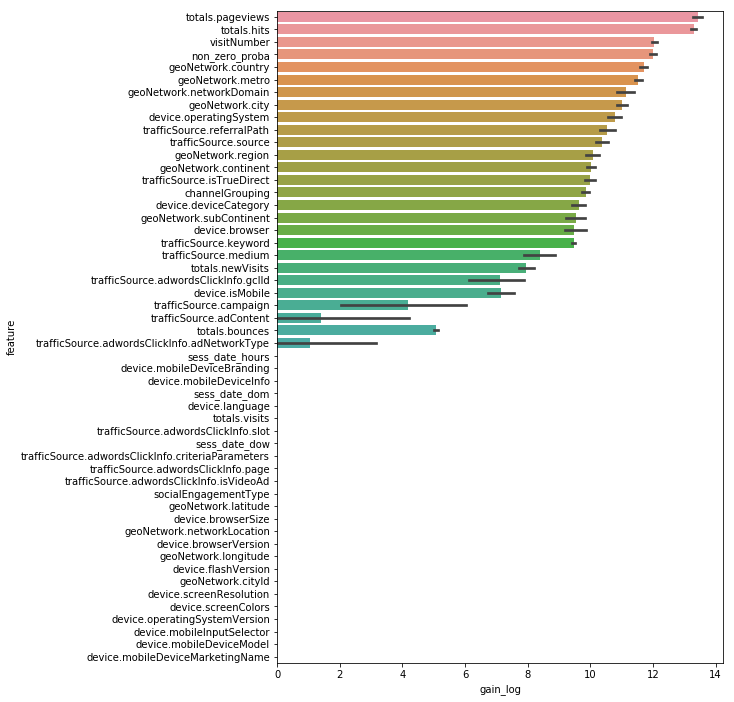

In [30]:
importances['gain_log'] = np.log1p(importances['gain'])
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 12))
sns.barplot(x='gain_log', y='feature', data=importances.sort_values('mean_gain', ascending=False))

KeyError: 'Column not found: totals.transactionRevenue'